In [1]:
%matplotlib inline

# Object detection in the street

This file is the main notebook (temporary just a structure now of all steps that we can do) for our DL4CV project. Our aim is to detect the object in the street by means of a convolutional neural network. The detection will be like a segmentation task with find out what each pixel of the object in a photo belongs to.

The Python version:

In [2]:
import sys
sys.version

'3.6.3 |Anaconda custom (64-bit)| (default, Oct 13 2017, 12:02:49) \n[GCC 7.2.0]'

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.autograd import Variable
import torch.nn as nn
import pandas as pd
import numpy as np
import math
import random
import os
from PIL import Image
from torch.utils.data import Dataset, sampler
from MyFolder import MyImageFolder
from visualisation import *
import matplotlib.pyplot as plt

### This step should be to load the data images and the label images (by pixel), while doing feature engineering


## Feature engineering

--In leftImg8bit.zip, the train and test images are all 8-bit 2048*1024 pixels png type images. 

--In gtCoarse, the train and test labels are all 2048*1024 pixels png type images, which ONLY color the road in pink and the small objects on it in blue, the other pixels are black.

-- ...

In [4]:
LABELSCSV = pd.read_csv("labels.csv")

In [5]:
print(LABELSCSV.shape)
#print(labelscsv)

(35, 10)


### The pre-training of the images contains the following steps:

--transforms each pixel from [0,255] to [0,1] 

--Normalisation for resnet

In [6]:
TRANSFORM = transforms.Compose(
#    [transforms.Scale(256),
#     [transforms.CenterCrop(224),     
     [transforms.ToTensor()])
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

TARGET_TRANSFORM = transforms.Compose(
#    [transforms.Scale(256),
#     [transforms.CenterCrop(224),  
     [transforms.ToTensor(),
     transforms.Normalize((0, 0, 0), (1/255, 1/255, 1/255))])

ROAD_LABELS = [1,2,7,8,9,10]#remove 8,9,10 to only keep the road
# WARNING does not change lowest_non_road_color yet

ROOT = '/mnt/disks/sdb1/cityscapes/'
LI8B = 'leftImg8bit/'
GT = 'gtFine/'
DATA_TRAIN = MyImageFolder(root1=ROOT+LI8B+'train', root2=ROOT+GT+'train_lido' , transform = TRANSFORM, target_transform= TARGET_TRANSFORM)
DATA_VAL = MyImageFolder(root1=ROOT+LI8B+'val', root2=ROOT+GT+'val_lido' , transform = TRANSFORM, target_transform= TARGET_TRANSFORM)
DATA_TEST = MyImageFolder(root1=ROOT+LI8B+'test', root2=ROOT+GT+'test_lido' , transform = TRANSFORM, target_transform= TARGET_TRANSFORM)


### An example of the data and its ground truth

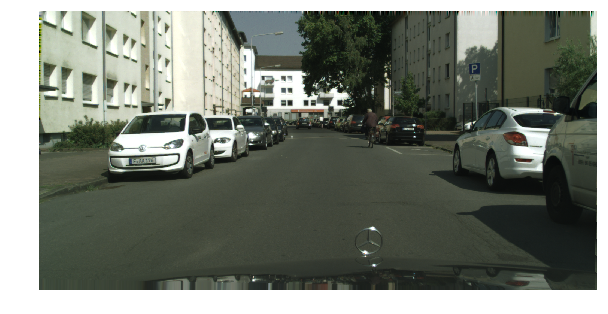

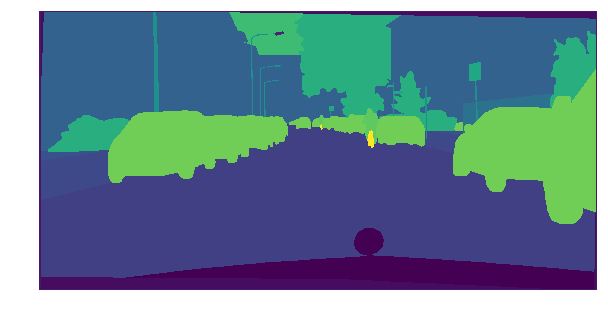

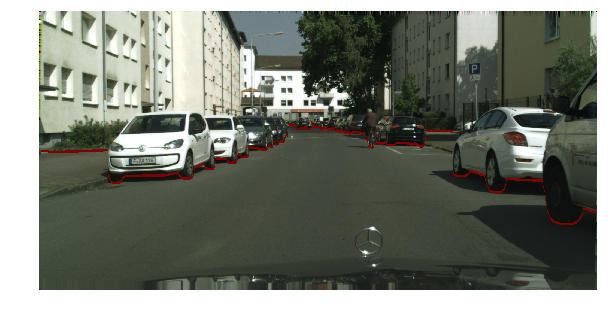

In [7]:
# Take an image and save its target

X,Y=DATA_VAL[1]


# img
fig=plt.figure(figsize=(10, 15))
plt.subplot(1,1,1)
plt.imshow(X.numpy().transpose(1,2,0))
plt.axis('off')
plt.show()
fig.savefig("img.jpg")
 

# segmentation target
TARGET = Y.numpy()
fig=plt.figure(figsize=(10, 15))
plt.subplot(1,1,1)
plt.imshow(TARGET)
plt.axis('off')
plt.show()
fig.savefig("segtgt.jpg")

# stixel target
fig=plt.figure(figsize=(10, 15))
plt.subplot(1,1,1)
plt.axis('off')
plt.imshow(lowest_non_road_color(X.numpy(), Y.numpy()))
plt.show()
fig.savefig("lnrtgt.jpg")

## Now we construct our net

In [8]:
from Mynet34 import PretrainedResNet34, MyNet
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

The hyper-parameters

In [9]:
NUM_CLASSES = 2
NB_TRAIN=len(DATA_TRAIN)
NB_VAL=len(DATA_VAL)
NB_TEST=len(DATA_TEST)

WEIGHTS_PATH = "../34-32-128-2.pth"
# where the weights are saved in the end, for further reuse

BATCH_SIZE = 1
USE_GPU = torch.cuda.is_available()

We take a pretrained Resnet

In [10]:
PRETRAINED_NET = PretrainedResNet34()
PRETRAINED_NET.load_state_dict(models.resnet34(pretrained=True).state_dict())
NET = MyNet(NUM_CLASSES, PRETRAINED_NET)
if USE_GPU:
    NET.cuda()

In [11]:
CRITERION = torch.nn.CrossEntropyLoss(ignore_index=-1)
if USE_GPU:
    CRITERION.cuda()
OPTIMIZER = optim.SGD(NET.parameters(), lr=0.01, momentum=0.9)

TRAIN_LOADER = DataLoader(DATA_TRAIN, batch_size=BATCH_SIZE, sampler=sampler.RandomSampler(DATA_TRAIN))
VAL_LOADER = DataLoader(DATA_VAL, batch_size=BATCH_SIZE)
TEST_LOADER = DataLoader(DATA_TEST, batch_size=BATCH_SIZE)

We take a pretrained model if it exists.

In [12]:
import os.path
if os.path.exists(WEIGHTS_PATH):
    NET.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights at:"+WEIGHTS_PATH)
else:
    print("No pretrained weights found at:"+WEIGHTS_PATH)

Loaded weights at:../34-32-128-2.pth


## Train and validate the StixelNet

In [13]:
NEEDS_NEW_EPOCH= True
LAST_TRAIN_LOSS=10
LAST_VAL_LOSS=10
#EPOCH=0
WIDTH=2048
SLICE_WIDTH=128
STRIDE=32
NUM_SLICES = (WIDTH - SLICE_WIDTH)//STRIDE +1    #added   "Integer Division"
PRINT_FREQUENCY=1024  

In [ ]:
print("Start training")


for epoch in range(1):
#while needNewEpoch:       
    #--------------------------------------training period---------------------------------------
    running_loss = 0.0
    epochloss = 0.0
    numsample=0
     
    NET.train()
    
    print ("Slice width: %5d\tStride: %5d \tNumber of Slices: %5d" %(WIDTH, STRIDE, NUM_SLICES))   #added  
    
    for inputs, labels in TRAIN_LOADER: 
        labels_masked = reduce(labels.numpy(), ROAD_LABELS)
        labels = torch.from_numpy(labels_masked)
        random_index = np.arange(NUM_SLICES)
        np.random.shuffle(random_index)
        
        for i in random_index:   ### added         
            inputs_temp = inputs[:, :, :, i*STRIDE : i*STRIDE + SLICE_WIDTH]   ### added
            labels_temp = labels[:, :, i*STRIDE : i*STRIDE + SLICE_WIDTH]   ### added      
            
            if USE_GPU:   
                inputs_temp = inputs_temp.cuda()    ### changed
                labels_temp = labels_temp.cuda()    ### changed
            
            inputs_temp, labels_temp = Variable(inputs_temp), Variable(labels_temp)     ### changed       
            # zero the parameter gradients
            OPTIMIZER.zero_grad()      
            # forward + backward + optimize
            outputs = NET(inputs_temp)                  ### changed
            loss = CRITERION(outputs, labels_temp)      ### changed
            loss.backward()
            OPTIMIZER.step()            
            # print statistics and save weights
            running_loss += loss.data[0]
            epochloss+=loss.data[0]
            numsample += BATCH_SIZE
            if numsample % PRINT_FREQUENCY == 0: #printfrequence-1: 
                print('[%d, %5d] loss: %.5f' %
                      (epoch+1, numsample, running_loss / PRINT_FREQUENCY),
                     end='\r', flush=True)
                running_loss = 0.0
                torch.save(NET.state_dict(),WEIGHTS_PATH[:-4]+"_temp.pth")

    newTrainLoss = epochloss/(NB_TRAIN*NUM_SLICES)   #changed
    print('The average loss of epoch ', epoch+1, ' is ', newTrainLoss)
    torch.save(NET.state_dict(),WEIGHTS_PATH)
    #--------------------------------------validation period---------------------------------------
    meanCorrectProba = 0.0
    epochloss = 0.0
    numsample=0
    NET.eval()
    print ("Slice width: %5d\tStride: %5d \tNumber of Slices: %5d" %(WIDTH, STRIDE, NUM_SLICES))
    for inputs, labels in VAL_LOADER:
        labels_masked = reduce(labels.numpy(), ROAD_LABELS)
        labels = torch.from_numpy(labels_masked)

        for i in range (NUM_SLICES): #added

            inputs_temp = inputs[:, :, :, i*STRIDE : i*STRIDE + SLICE_WIDTH]   ### added
            labels_temp = labels[:, :, i*STRIDE : i*STRIDE + SLICE_WIDTH]   ### added    
            
            if USE_GPU:
                inputs_temp = inputs_temp.cuda()    #changed
                labels_temp = labels_temp.cuda()    #changed    
                
            inputs_temp, labels_temp = Variable(inputs_temp), Variable(labels_temp) #changed
            outputs=NET(inputs_temp)    #changed
            loss = CRITERION(outputs, labels_temp) #changed
            meanProbability=np.exp(-loss.data[0])
            epochloss += loss.data[0]
            meanCorrectProba += meanProbability
            numsample += BATCH_SIZE
       
    newValLoss = epochloss / (NB_VAL*NUM_SLICES) 
    print('The average validation loss is ', newValLoss)
    print('The average correctness of the validation data is ', meanCorrectProba/(NB_VAL*NUM_SLICES)*100, '%')   #changed
    #--------------------------------------evaluate the necessity of a new epoch---------------------------------------
    if (LAST_VAL_LOSS-newValLoss<0.01) and (LAST_TRAIN_LOSS-newTrainLoss<0.01):
        needNewEpoch=False
    else:
        lastloss=newValLoss 
        #epoch=epoch+1
    LAST_VAL_LOSS = newValLoss
    LAST_TRAIN_LOSS = newTrainLoss

print("End training")


 ## Visualization

381.0


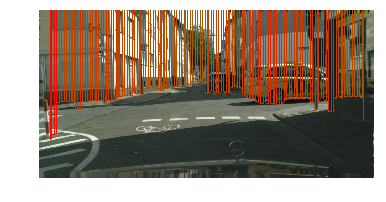

225.0


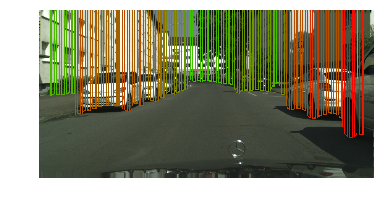

KeyboardInterrupt: 

In [15]:
OFFSET = SLICE_WIDTH - 2 * STRIDE
MSE = 0
SHOW_IMGS = True # false for only "MSE"
for i in range (100):#(NB_VAL):
    print(i, end='\r', flush=True)
    x,y=DATA_VAL[i]
    inputs = x.unsqueeze(0)
    outputs = inputs[:,0:2,:,:].clone()
    
    for j in range (NUM_SLICES): #added

            inputs_temp = inputs[:, :, :, j*STRIDE : j*STRIDE + SLICE_WIDTH]   ### added
            
            if USE_GPU:
                inputs_temp = inputs_temp.cuda()    
                
            inputs_temp = Variable(inputs_temp)
            outputs[:, :, :, j*STRIDE+OFFSET : (j+1)*STRIDE+OFFSET]=\
            NET(inputs_temp).data[:, :, :, OFFSET : STRIDE+OFFSET]
    _, preds = torch.max(outputs, 1)
    pred = preds[0].cpu()
    img, target = x.numpy(), y.numpy()
    red = reduce(target, ROAD_LABELS)
    npred = pred.numpy()
    es = edge_smoother(npred)
    
    comp = compare(red, es)
    print(comp)
    MSE += comp
    if SHOW_IMGS:
        fig = plt.figure()
        plt.subplot(1,1,1)
        plt.axis('off')
        sb = stixel_bar(img, es, STRIDE, OFFSET)
        plt.imshow(sb)
        plt.show()
        fig.savefig("compare/"+str(i)+".jpg")
print("MMSE is: " + str(MSE // 100))

# [ARCHIVE]

_The following is not supposed to be run, only kept for reference_

## Train and validate the SegmentNet

In [ ]:
print("Start training")

needNewEpoch= True
lastTrainLoss=10
lastValLoss=10
epoch=0

for epoch in range(1):  # loop over the dataset multiple times
#while needNewEpoch:       
    #--------------------------------------training period---------------------------------------
    running_loss = 0.0
    epochloss = 0.0
    numsample=0
    printfrequence=20
    
    net.train()
    for inputs, labels in trainloader:
        if useGPU:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
   
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.data[0]
        epochloss+=loss.data[0]
        numsample += batchsize
        if numsample % printfrequence == 0: #printfrequence-1: 
            print('[%d, %5d] loss: %.5f' % (epoch+1, numsample, running_loss / printfrequence))
            running_loss = 0.0
    newTrainLoss = epochloss/nbtrain        
    print('The average loss of epoch ', epoch+1, ' is ', newTrainLoss)
    torch.save(net.state_dict(),weightpath)
    #--------------------------------------validation period---------------------------------------
    meanCorrectProba = 0.0
    epochloss = 0.0
    numsample=0
    printfrequence=200
    
    net.eval()
    for inputs, labels in valloader:
        if useGPU:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs, labels = Variable(inputs), Variable(labels)
        outputs=net(inputs)
        loss = criterion(outputs, labels)
        meanProbability=np.exp(-loss.data[0])
        
        # print statistics
        epochloss += loss.data[0]
        meanCorrectProba += meanProbability
        numsample += batchsize
        #if numsample % printfrequence == 0: #printfrequence-1: 
        #    print(numsample, ' validation images passed')
    newValLoss = epochloss / nbval
    print('The average validation loss is ', newValLoss)
    print('The average correctness of the validation data is ', meanCorrectProba/nbval*100, '%')
    #--------------------------------------evaluate the necessity of a new epoch---------------------------------------
    if (lastValLoss-newValLoss<0.01) and (lastTrainLoss-newTrainLoss<0.01):
        needNewEpoch=False
    else:
        lastLoss=newValLoss 
        #epoch=epoch+1

print("End training")

In [ ]:
meanCorrectProba = 0.0
numsample=0
printfrequence=20
    
net.eval()
for inputs, labels in trainloader:
    if useGPU:
        inputs = inputs.cuda()
        labels = labels.cuda()
    inputs, labels = Variable(inputs), Variable(labels)
    outputs=net(inputs)
    loss = criterion(outputs, labels)
    meanProbability=np.exp(-loss.data[0])
        
    # print statistics
    meanCorrectProba += meanProbability
    numsample += batchsize
#    if numsample % printfrequence == 0: #printfrequence-1: 
#        print('[%d, %5d] loss: %.5f' % (epoch+1, numsample, running_loss / printfrequence))
#        running_loss = 0.0
print('The average correctness of the validation data is ', meanCorrectProba/nbval*100, '%')

 # Visualization

In [ ]:
NB_SAMPLE_IMGS = 4
plt.figure(figsize=(15, 5 * NB_SAMPLE_IMGS))
for i in range (NB_SAMPLE_IMGS):
    x,y=dataval[i]
    inputs = x.unsqueeze(0)
    
    
    """
    # Segmentation
    inputs = Variable(inputs)
    if useGPU:
        inputs = inputs.cuda()
    
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    """
    # Stixels
    outputs = inputs.copy()
    for i in range(num_slices):
        inputs_temps = Variable(inputs[:,:,:,i*slice_width : (i+1)*slice_width0])
        if useGPU:
            inputs_temp = inputs_temp.cuda()
        outputs[:,:,:,i*slice_width : (i+1)*slice_width0] = \
        net(inputs_temp)
    _, preds = torch.max(outputs, 1)
    pred = preds[0].data.cpu()
    
    
    img, target, pred = x.numpy(), y.numpy(), pred.numpy()
    
    # img
    plt.subplot(NB_SAMPLE_IMGS, 3, i * 3 + 1)
    plt.axis('off')
    plt.imshow(img.transpose(1,2,0))
    if i == 0:
        plt.title("Input image")
    
    # target
    plt.subplot(NB_SAMPLE_IMGS, 3, i * 3 + 2)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(target))
    if i == 0:
        plt.title("Target image")

    # pred
    plt.subplot(NB_SAMPLE_IMGS, 3, i * 3 + 3)
    plt.axis('off')
    plt.imshow(label_img_to_rgb(pred))
    if i == 0:
        plt.title("Prediction image")
    
plt.show()